In [377]:
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("../data/datasets/abs_60topics_filt_jul.pkl")

In [378]:
from IPython.html import widgets
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [379]:
import numpy as np
from base import plotting
from base.classifiers import OnevsallClassifier, PairwiseClassifier, OnevsallContinuous
import base.classifiers.pairwise as pw
import base.classifiers.onevsall as oa
import glob
import pandas as pd
from ggplot import *
from base import tools
from scipy import stats
import itertools
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab
import base.classifiers.pairwise as mc
from base.statistics import dcor
import re

In [380]:
mpld3.enable_notebook()

In [381]:
%%R
library(ggplot2)
library(dplyr)
library(MASS)
library(reshape2)

# Active or not - hard zero

In [382]:
clfs = [OnevsallContinuous.load(clf + "/classifier.pkl") for clf in glob.glob("../results/wardmin75*cog*")]

In [383]:
plot_score = []
all_scores = []
for clfs in [clfs]:
    for clf in clfs:
        for n, score in enumerate(clf.class_score):
            all_scores.append([clf.mask_num, n, clf.n_features_orig, 'clf' , score])
        plot_score.append([clf.mask_num, clf.n_features_orig, 'clf' , clf.class_score.mean()])


In [384]:
plot_score = pd.DataFrame(plot_score, columns=['n_regions', 'n_topics', 'clf', 'r2'])
plot_score['n_regions'] = plot_score['n_regions'].apply(str)

all_scores = pd.DataFrame(all_scores, columns=['n_regions', 'region', 'n_topics', 'clf', 'r2'])
all_scores['n_regions'] = all_scores['n_regions'].apply(str)

In [385]:
from base.tools import region_n_vox
n_vox = []
for regions in clfs:
    n_vox = n_vox + list(itertools.izip(itertools.repeat(regions.mask_num), range(0, regions.mask_num), 
                                     list(region_n_vox(dataset, regions.mask_img))))
n_vox = pd.DataFrame(n_vox, columns=['n_regions', 'region', 'voxels'])
n_vox['n_regions'] = n_vox['n_regions'].apply(str)


In [386]:
all_scores = pd.merge(all_scores, n_vox)
%Rpush all_scores

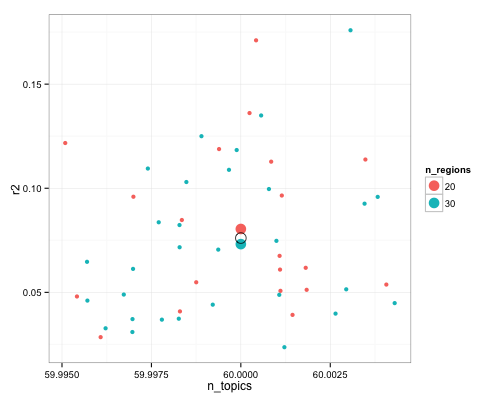

In [387]:
%%R -w 500 -h 400
ggplot(all_scores, aes(n_topics, r2, color=n_regions)) + geom_point(position=position_jitter(width=0.005)) +
 stat_summary(fun.y=mean, geom='point', size=5) + stat_summary(fun.y=mean, geom='point', size=5, shape=1, color="black") + theme_bw()  

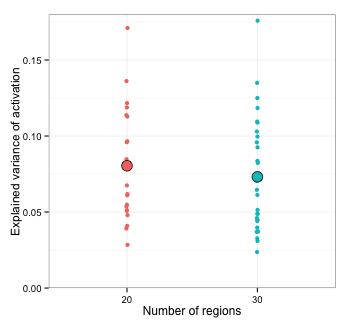

In [388]:
%%R -w 350 -h 325
ggplot(all_scores, aes(n_regions, r2, color=n_regions)) + geom_point(position=position_jitter(width=0.005)) +
 stat_summary(fun.y=mean, geom='point', size=5) + stat_summary(fun.y=mean, geom='point', size=5, shape=1, color="black") + theme_bw() + theme(legend.position='none') +
coord_cartesian(ylim = c(0, .18)) + ylab("Explained variance of activation") + xlab("Number of regions")
# ggsave("../reports/whole_brain_paper/figures/reg_variance.png")

In [389]:
np.sqrt(all_scores.r2.mean())

0.2758098599580191

In [390]:
all_scores.r2.mean()

0.076071078850062118

In [391]:
np.sqrt(all_scores.r2.min())

0.15381686812171097

In [392]:
np.sqrt(all_scores.r2.max())

0.41934626467967473

In [393]:
all_scores.groupby(['n_regions', 'n_topics']).agg(np.mean)

,,region,r2,voxels
n_regions,n_topics,,,
20,60,9.5,0.080436,8078.050000
30,60,14.5,0.073161,5385.366667


In [394]:
all_scores.groupby('n_regions').describe()

n_topics         r2     region        voxels
n_regions                                                    
20        count        20  20.000000  20.000000     20.000000
          mean         60   0.080436   9.500000   8078.050000
          std           0   0.038515   5.916080   8866.987256
          min          60   0.028445   0.000000    540.000000
          25%          60   0.051108   4.750000   3133.500000
          50%          60   0.064649   9.500000   4815.500000
          75%          60   0.113052  14.250000   9002.750000
          max          60   0.171058  19.000000  33432.000000
30        count        30  30.000000  30.000000     30.000000
          mean         60   0.073161  14.500000   5385.366667
          std           0   0.036911   8.803408   5803.121470
          min          60   0.023660   0.000000    513.000000
          25%          60   0.044270   7.250000   1579.500000
          50%          60   0.067593  14.500000   3489.000000
          75%          60   0.098669  21.750000   6260.750000
          max          60   0.175851  29.000000  26371.000000

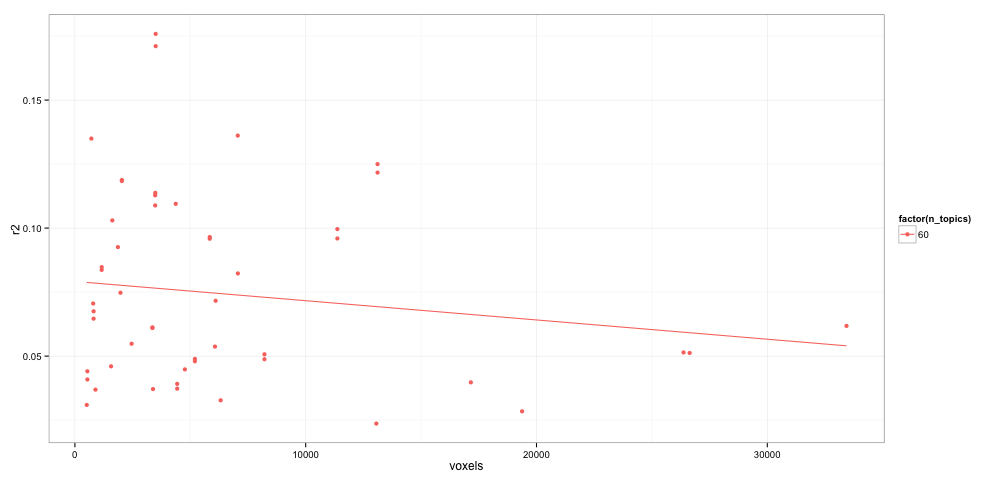

In [395]:
%%R -w 1000 -h 480 -u px
ggplot(all_scores, aes(voxels, r2, color=factor(n_topics))) + geom_point(size = 2) + theme_bw() + stat_smooth(method=rlm, se=F)

In [396]:
num_regions = 30
num_topics = 60

In [397]:
o_clf = [clf for clf in clfs if (clf.mask_num == num_regions) & (clf.n_features_orig == num_topics)][0]


In [398]:
o_clf.mask_img

'../results/cluster/cls_3mm_ward_coact_min75v/ward_k30/cluster_labels.nii.gz'

In [399]:
o_clf.class_score.mean()

0.073160895999522524

In [400]:
# tools.make_mask_map(o_clf.class_score, o_clf.mask_img, '../results/wardmin75_' + str(num_regions) + '_Ridge_abs_topics_filt/class_scores')

In [401]:
all_scores.region = all_scores.region+1

### Discriminability by base rate

In [402]:
# Set region and classifier for following analyses
base_rates = tools.region_vox_baserates(dataset, o_clf.mask_img)

In [403]:
%Rpush base_rates

In [404]:
acc = all_scores[(all_scores['n_topics'] == num_topics) & (all_scores['n_regions'] == str(num_regions))].copy()

pl = pd.merge(base_rates, acc)
%Rpush pl

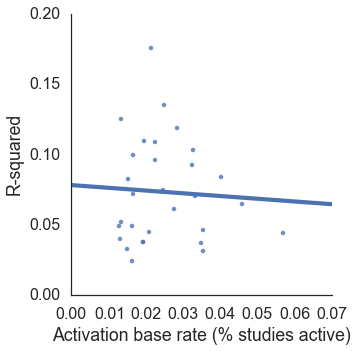

In [405]:
mean_br = pl.groupby(['region']).agg(np.mean).reset_index()
mean_br_plot = mean_br.rename(columns = {'base_rate':'Activation base rate (% studies active)', 'r2': "R-squared"})
br_auc_oplot = sns.lmplot('Activation base rate (% studies active)', 'R-squared', mean_br_plot, ci=None)
tooltip = mpld3.plugins.PointLabelTooltip(br_auc_oplot.axes[0][0].collections[0], labels=list(mean_br.region))
fig = plt.gcf()
mpld3.plugins.connect(fig, tooltip)
%Rpush mean_br

In [406]:
stats.pearsonr(mean_br.r2, mean_br.base_rate)

(-0.056883150383201228, 0.76527207552333931)

## Feature importance analysis

In [407]:
reload(oa)

<module 'base.classifiers.onevsall' from 'base/classifiers/onevsall.pyc'>

In [408]:
sns.heatmap

<function seaborn.matrix.heatmap>

In [409]:
o_clf.feature_importances[4, 5]

0.00013703187539346762

In [410]:
o_clf.feature_importances.shape

(30, 35)

In [411]:
o_clf.feature_importances.min()

-0.0048731921129294264

What are the top features overall?

In [412]:
mean_fis = pd.DataFrame(np.array([np.round(o_clf.feature_importances.mean(axis=0), 3), o_clf.feature_names]).T, columns=['mean_fi', 'topic_name'])

In [413]:
word_keys = pd.read_csv("../data/unprocessed/abstract_topics_filtered/topic_sets/top_words_" + str(num_topics) + ".csv")

In [414]:
word_keys['top_2'] = word_keys.top_words.apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])

In [415]:
word_keys.top_words[0].split(' ')[0] + ", " + word_keys.top_words[0].split(' ')[1]

'women, sex'

In [416]:
mean_fis = pd.merge(mean_fis, word_keys)

In [417]:
mean_fis

,mean_fi,topic_name,top_words,top_2
0,-0.0,topic1,stress awareness experience,stress awareness
1,0.0,topic2,eye gaze movements,eye gaze
2,0.002,topic4,decision choice risk,decision choice
3,0.001,topic5,reasoning rule rules,reasoning rule
4,0.005,topic6,visual auditory sensory,visual auditory
5,0.002,topic7,spatial location mental,spatial location
6,0.001,topic9,repetition priming hearing,repetition priming
7,0.001,topic10,visual category adaptation,visual category
8,0.001,topic11,memory events imagery,memory events
9,-0.001,topic12,object objects visual,object objects


In [418]:
# print mean_fis.sort('mean_fi', ascending=False).values

In [419]:
# The mean of the feature importances predicts the classification score
stats.pearsonr(o_clf.feature_importances.mean(axis=1), o_clf.class_score)

(0.095832746927525178, 0.61443291971413339)

In [420]:
# The absolute mean of the feature importances predicts the classification score
stats.pearsonr(np.abs(o_clf.feature_importances.mean(axis=1)), o_clf.class_score)

(0.10812617212973945, 0.56953373485128478)

In [421]:
# The variance of the feature importances predicts the classification score
stats.pearsonr(o_clf.feature_importances.var(axis=1), o_clf.class_score)

(0.65481361122193038, 8.6297434925556403e-05)

In [422]:
o_fi = pd.DataFrame(o_clf.feature_importances)

# Melt feature importances, and add top_words for each feeature
o_fi['region'] = range(1, o_fi.shape[0] + 1)
o_fis_melt = pd.melt(o_fi, var_name='topic_order', value_name='importance', id_vars=['region'])

In [423]:
o_fis_melt= pd.merge(o_fis_melt, keys)


In [424]:
o_fi = pd.DataFrame(o_clf.feature_importances)

# Melt feature importances, and add top_words for each feeature
o_fi['region'] = range(1, o_fi.shape[0] + 1)
o_fis_melt = pd.melt(o_fi, var_name='topic_order', value_name='importance', id_vars=['region'])

keys = pd.merge(pd.DataFrame(np.array([range(0, o_clf.feature_importances.shape[1]), o_clf.feature_names]).T, columns=['topic_order', 'topic_name']), word_keys)
keys.topic_order = keys.topic_order.astype('int')

o_fis_melt= pd.merge(o_fis_melt, keys)
o_fis_melt['abs_imp'] = np.abs(o_fis_melt['importance'])

o_fis_melt = pd.merge(o_fis_melt, mean_br)
%Rpush o_fis_melt

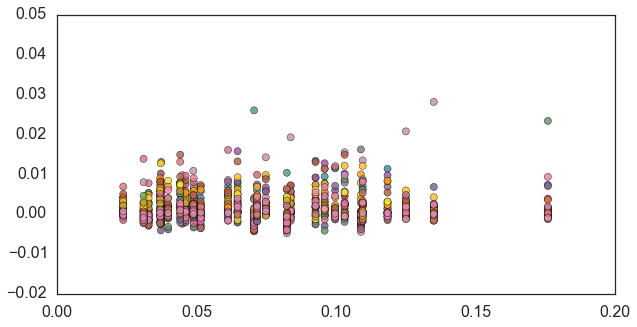

In [425]:
categories = np.unique(o_fis_melt['topic_name'])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))
o_fis_melt["Color"] = o_fis_melt['topic_name'].apply(lambda x: colordict[x])

pylab.rcParams['figure.figsize'] = 10, 5  # that's default image size for this interactive session
sns.set_style("white")
scatter = plt.scatter(o_fis_melt.r2, o_fis_melt.importance, c=o_fis_melt.Color, cmap=cm.Set1, s=50, alpha=0.8)
fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(zip(o_fis_melt.region.values, o_fis_melt.top_words.values)))
mpld3.plugins.connect(fig, tooltip)


In [426]:
mpld3.disable_notebook()

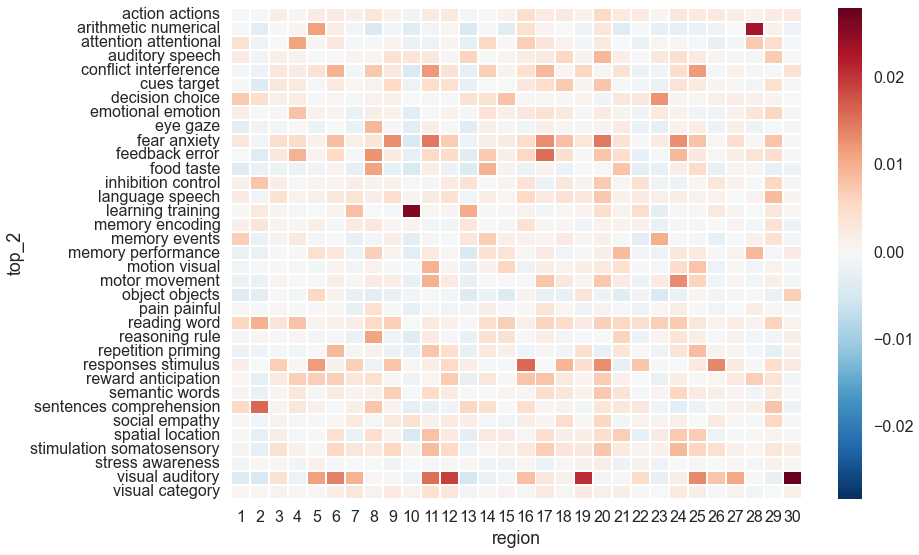

In [427]:
sns.set_context('poster')
sns.heatmap(pd.pivot_table(o_fis_melt, values='importance', index=['top_2'], columns=['region']))

In [428]:
o_fis_melt.groupby('topic_name').mean().sort('importance')

,region,importance,abs_imp,base_rate,n_topics,r2,voxels,Color
topic_name,,,,,,,,
topic12,15.5,-0.000874,0.002166,0.024905,60,0.073161,5385.366667,0.088235
topic1,15.5,-0.000005,0.000755,0.024905,60,0.073161,5385.366667,0.000000
topic2,15.5,0.000049,0.001640,0.024905,60,0.073161,5385.366667,0.176471
topic53,15.5,0.000103,0.002684,0.024905,60,0.073161,5385.366667,0.794118
topic59,15.5,0.000262,0.001004,0.024905,60,0.073161,5385.366667,0.911765
topic26,15.5,0.000405,0.002813,0.024905,60,0.073161,5385.366667,0.294118
topic48,15.5,0.000798,0.001350,0.024905,60,0.073161,5385.366667,0.676471
topic5,15.5,0.000872,0.001855,0.024905,60,0.073161,5385.366667,0.735294
topic11,15.5,0.001033,0.002086,0.024905,60,0.073161,5385.366667,0.058824


In [429]:
# %%R -w 1000 -h 700
# library(colorRamps)
# library(RColorBrewer)
# getPalette = colorRampPalette(brewer.pal(9, "Set1"))


# ggplot(o_fis_melt, aes(r2, importance, color=factor(topic_name))) +
# geom_abline(intercept = 0, slope = 0) + geom_point(position=position_jitter(width=.0005), size=2) + 
# stat_summary(fun.y=mean, size=5, geom='point')+ 
# stat_summary(fun.y=mean, size=5, geom='point', color='black', shape=1, alpha=0.5) + theme_bw() + theme(legend.position='none') +
# scale_color_manual(values = getPalette(80)) + xlab ("Discriminability (area under ROC)") + ylab("Topic prediction weight") +
# theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.border = element_blank(),
#      axis.title.x = element_text(size=15), axis.title.y = element_text(size=15), axis.text.x = element_text(size=13), axis.text.y = element_text(size=13))

12 - bilateral middle LPFC - sentences, language, reading, memory, cogntive control, wm
14 - IFJ - language memory cognitive
21- Anterior DLPFC
26 - vmpfc - social, reward, network 
27 - mPFC - pain, emotion

In [430]:
top_topics = o_fis_melt[o_fis_melt.importance > 0.002][['region', 'topic_name', 'importance', 'top_words']]

In [431]:
top_topics.topic_name = top_topics.topic_name.apply(lambda x: re.sub("[^0-9]", "", x))

In [432]:
top_topics['word'] = top_topics.top_words.apply(lambda x: x.split(' ')[0] + " " + x.split(' ')[1] )

In [433]:
top_topics.importance = top_topics.importance / top_topics.importance.min()

In [434]:
top_topics.importance = top_topics.importance.round()

In [435]:
new_topics = []
for row in top_topics.iterrows():
    new_row = list(row[1][['region', 'topic_name', 'word']])
    new_topics += [new_row] * int(row[1].importance)


In [436]:
pd.DataFrame(new_topics, columns=['region', 'topic', 'word']).to_csv("topic_loadings_2.csv")

In [437]:
o_fi_acc_sum = o_fis_melt.groupby('region').agg(np.mean)

In [438]:
o_fi_acc_sum = o_fi_acc_sum.reset_index()

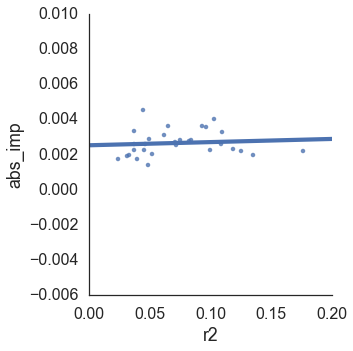

In [439]:
mean_imp_auc_p = sns.lmplot('r2', 'abs_imp', o_fi_acc_sum, ci=None)
tooltip = mpld3.plugins.PointLabelTooltip(mean_imp_auc_p.axes[0][0].collections[0], labels=list(o_fi_acc_sum.region))
fig = plt.gcf()
mpld3.plugins.connect(fig, tooltip)
%Rpush mean_br

In [440]:
np.sqrt(o_fi_acc_sum.r2.max())

0.41934626467966946

In [441]:
o_fis_melt.r2.min()

0.023659628918777237

## Bar plots

In [442]:
zscore = lambda x: (x - x.mean()) / x.std()
o_fis_melt['importance_z'] = o_fis_melt.groupby('region')['importance'].apply(zscore)

In [443]:
labels = ['vmPFC', 'PCC',  'DLPFC','Hipp/Amygdala', 'Anterior Insula', 'NACC', 'Primary Motor (left)']
regions = np.array([13,  23, 9, 2, 20, 10, 30])
labels = zip(list(regions), labels)
# 10 = dlpfc cluster
selected_regions = o_fis_melt[np.in1d(o_fis_melt.region,regions) ]


In [444]:
from base import img_tools

In [445]:
# Top_3
sel_topics = selected_regions[selected_regions.groupby('region').rank(ascending=False).abs_imp < 3]
top_n = selected_regions[np.in1d(selected_regions.topic_name, sel_topics.topic_name) ]

top_n['region_names'] = top_n['region'].map(dict(labels))


%Rpush top_n
%Rpush regions

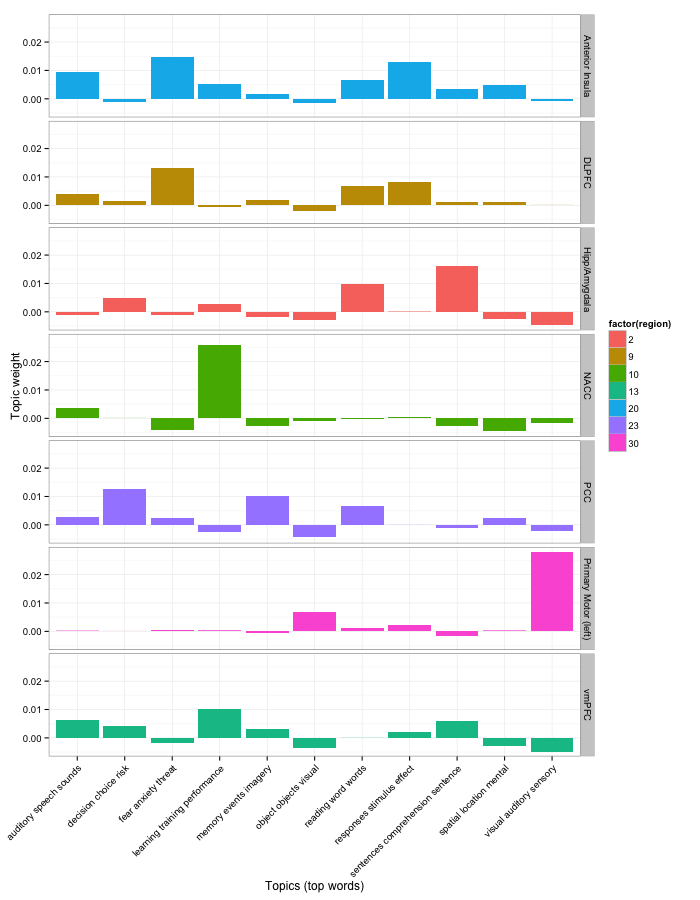

In [446]:
%%R -w 700 -h 900
library(ggplot2)

ggplot(top_n, aes(top_words, importance, fill=factor(region))) + geom_bar(stat='identity') + 
theme_bw() + theme(axis.text.x=element_text(angle = 45, hjust=1)) + 
facet_grid(region_names~.) + ylab("Topic weight") + xlab("Topics (top words)") 
# scale_fill_manual(values = rev(vmpfc_30_colors))
# theme(strip.text.y = element_blank(), strip.background = element_blank())


# ggsave("../reports/vmpfc_comps/bar_top3_30.pdf")

In [447]:
top_n.groupby('region').mean().sort('r2')

,importance,abs_imp,base_rate,n_topics,r2,voxels,Color,importance_z
region,,,,,,,,
23,0.002443,0.004277,0.019228,60,0.037126,3383,0.52139,0.548348
9,0.003198,0.003669,0.019392,60,0.037297,4432,0.52139,0.358800
20,0.005065,0.005681,0.056792,60,0.044088,540,0.52139,0.217535
10,0.001188,0.004248,0.033201,60,0.070550,791,0.52139,0.331647
13,0.001763,0.004115,0.015179,60,0.082298,7061,0.52139,0.610275
2,0.001775,0.004333,0.022404,60,0.108847,3478,0.52139,0.412624
30,0.003376,0.003763,0.024953,60,0.134964,712,0.52139,0.410265


In [448]:
tools.make_mask_map(selected_regions.groupby('region').mean().r2, o_clf.mask_img, '../results/wardmin75_30_Ridge_abs_topics_filt/class_score.nii.gz', index=regions -1)

#Multivarate plots

In [449]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import make_scorer
from base.mv import calc_mv
from sklearn.metrics import auc
regions.sort()

In [450]:
mv_results = calc_mv(o_clf, make_scorer(explained_variance_score), regions=regions-1, processes=7)
mv_results.region = mv_results.region +1

[##########] 100%


In [451]:
mv_results['region_names'] = mv_results['region'].map(dict(labels))

In [452]:
unit_norm = lambda x: (x / x.max())
mv_results['score_unit'] = mv_results.groupby('region')['score'].apply(unit_norm)

%Rpush mv_results

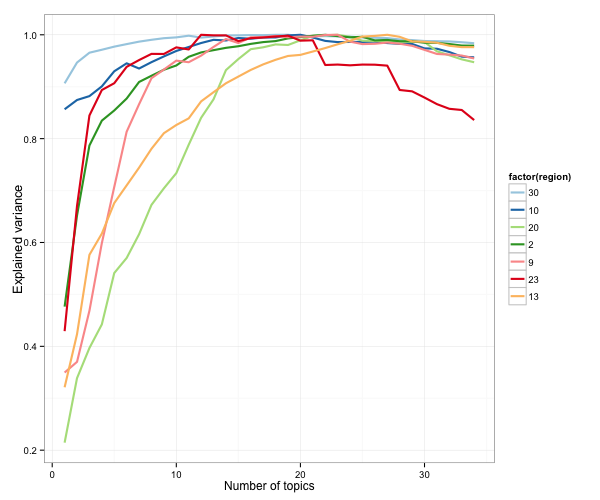

In [453]:
%%R -w 600 -h 500

ten_colors = c("#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a")
mv_results$region <- factor(mv_results$region, levels = rev(regions))

library(ggplot2)
ggplot(mv_results, aes(num_features, score_unit, color=factor(region))) + theme_bw() + ylab("Explained variance" ) + xlab("Number of topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 0.2))  + stat_summary(fun.y=mean, geom="line", size=1) +
scale_color_manual(values=ten_colors)

# ggsave("../reports/vmpfc_comps/mv_ev_unit_complete.pdf")

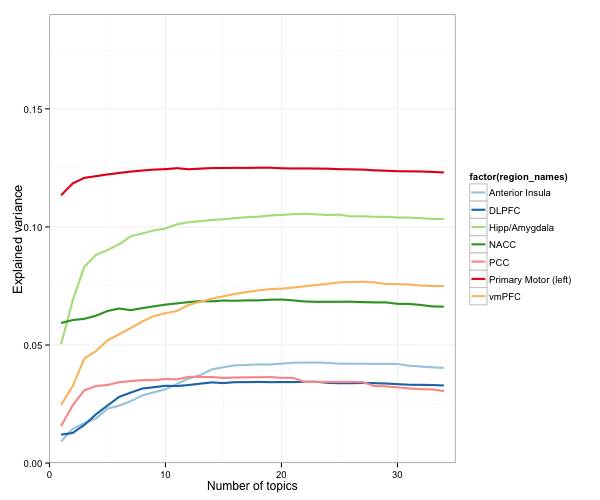

In [454]:
%%R -w 600 -h 500
library(ggplot2)
ggplot(mv_results, aes(num_features, score, color=factor(region_names))) + theme_bw() + ylab("Explained variance" ) + xlab("Number of topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 0.2))  + stat_summary(fun.y=mean, geom="line", size=1) + 
 coord_cartesian(xlim = c(0, 35), ylim=c(0, 0.19)) + scale_color_manual(values=ten_colors)

# ggsave("../reports/vmpfc_comps/mv_ev_abs_complete.pdf")

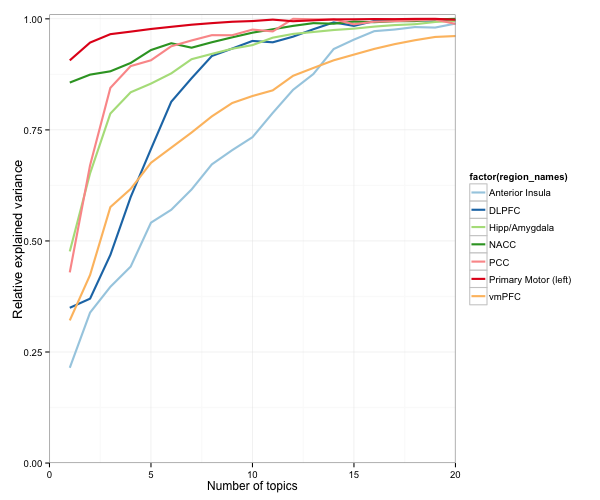

In [455]:
%%R -w 600 -h 500
library(ggplot2)
ggplot(mv_results, aes(num_features, score_unit, color=factor(region_names))) + theme_bw() + ylab("Relative explained variance" ) + xlab("Number of topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 0.2)) + coord_cartesian(xlim = c(0, 20), ylim=c(0, 1.01)) + stat_summary(fun.y=mean, geom="line", size=1) +
scale_color_manual(values = ten_colors) 
# + geom_vline(xintercept=5, linetype=5, alpha=0.7)

# ggsave("../reports/vmpfc_comps/mv_ev_abs_25.pdf")

In [456]:
mv_results.groupby('region').apply(lambda x: auc(x['num_features'], x['score_unit']))

region
2         31.100444
9         29.865915
10        31.911747
13        28.803423
20        27.683572
23        30.552715
30        32.637551
dtype: float64

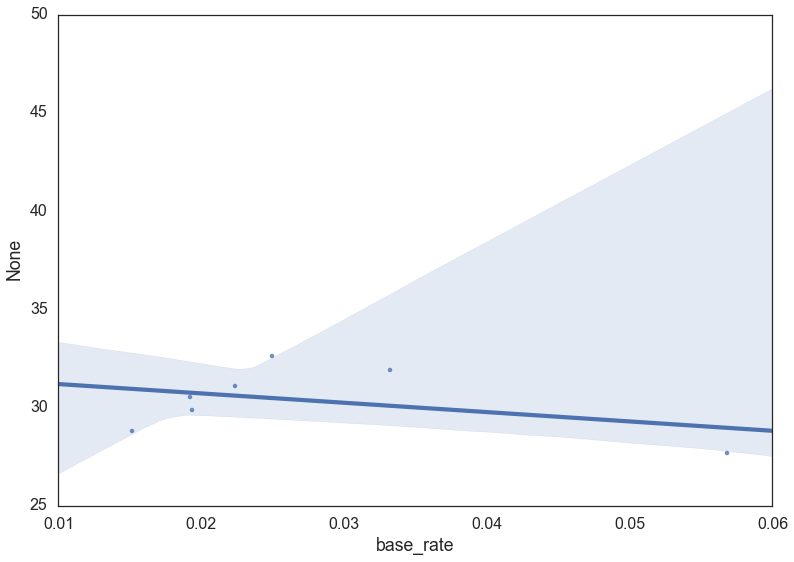

In [457]:
sns.regplot(selected_regions.groupby('region').mean().base_rate, mv_results.groupby('region').apply(lambda x: auc(x['num_features'], x['score_unit'])))

In [458]:
mv_results.groupby('region').apply(lambda x: auc(x['num_features'], x['score_unit']))

region
2         31.100444
9         29.865915
10        31.911747
13        28.803423
20        27.683572
23        30.552715
30        32.637551
dtype: float64

In [459]:
mv_results.query('num_features <= 10').groupby('region').apply(lambda x: auc(x['num_features'], x['score_unit']))

region
2         7.476726
9         6.323430
10        8.285220
13        5.911429
20        4.755906
23        7.833796
30        8.763922
dtype: float64

In [460]:
tools.make_mask_map(mv_results.query('num_features <= 10').groupby('region').apply(
    lambda x: auc(x['num_features'], x['score_unit'])).values, o_clf.mask_img, 
        '../results/ward_f' + str(num_regions) + '_Ridge_abs_topics' + str(num_topics) + '_filt/mv_auc_10f_vmpfc', index=regions - 1)

In [461]:
mv_results.query('num_features <= 10').groupby('region').apply(
    lambda x: auc(x['num_features'], x['score_unit'])).values

array([ 7.47672635,  6.32343006,  8.2852195 ,  5.91142897,  4.75590578,
        7.83379594,  8.76392227])

In [462]:
def cum_auc(df):
    results = []
    for i in range(3, df['num_features'].max() + 2):
        new_df = df.query('num_features < ' +str(i))
        results.append(auc(new_df['num_features'], new_df['score_unit']))
        
    results = pd.DataFrame(results).reset_index(level=0)   
    results.columns = ['num_features', 'cum_auc']
    results.num_features = results.num_features +2
    return results

In [463]:
test_df = mv_results[mv_results['region'] == 2]

In [464]:
cumauc_mv_vmpfc = mv_results.groupby('region').apply(lambda x: cum_auc(x))

In [465]:
cumauc_mv_vmpfc.reset_index(level=0, inplace=True)
%Rpush cumauc_mv_vmpfc

### All regions

In [466]:
mv_results_all = calc_mv(o_clf, make_scorer(explained_variance_score), processes=7)
mv_results_all.region = mv_results_all.region +1

[##########] 100%


In [467]:
mv_results_all['score_unit'] = mv_results_all.groupby('region')['score'].apply(unit_norm)
%Rpush mv_results_all

In [468]:
mv_auc = mv_results_all.query('num_features < 20').groupby('region').apply(lambda x: auc(x['num_features'], x['score_unit'])).values

In [469]:
(1 / mv_auc)[9]

0.05819018677022654

In [470]:
tools.make_mask_map(1 / mv_auc, o_clf.mask_img, '../results/wardmin75_' + str(num_regions) + '_Ridge_abs_topics_filt/mv_auc_20f')

In [471]:
tools.make_mask_map( o_fis_melt.groupby('region').mean().base_rate, o_clf.mask_img, '../results/wardmin75_' + str(num_regions) + '_Ridge_abs_topics_filt/base_rate')

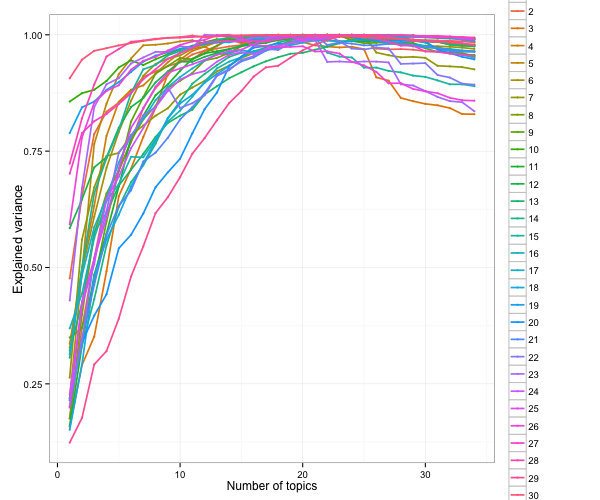

In [472]:
%%R -w 600 -h 500
library(ggplot2)
ggplot(mv_results_all, aes(num_features, score_unit, color=factor(region))) + stat_summary(fun.y=mean, geom="point", size=1) + theme_bw() + ylab("Explained variance" ) + xlab("Number of topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 0.2))  + stat_summary(fun.y=mean, geom="line", size=0.8)

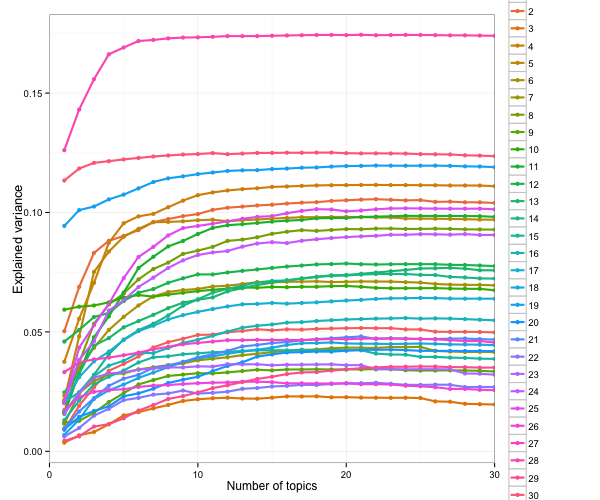

In [473]:
%%R -w 600 -h 500
ggplot(mv_results_all, aes(num_features, score, color=factor(region))) + stat_summary(fun.y=mean, geom="point", size=2) + 
theme_bw() + ylab("Explained variance" ) + xlab("Number of topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 0.2)) + coord_cartesian(xlim = c(0, 30)) + 
stat_summary(fun.y=mean, geom="line", size=1)

In [474]:
%%R -w 600 -h 500
ggplot(mv_results_all, aes(num_features, score_log_t50, color=factor(region))) + stat_summary(fun.y=mean, geom="point", size=2) + 
theme_bw() + ylab("Explained variance" ) + xlab("Number of topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 0.2)) + coord_cartesian(xlim = c(0, 30)) + 
stat_summary(fun.y=mean, geom="line", size=1)

RRuntimeError: Error in eval(expr, envir, enclos) : object 'score_log_t50' not found


In [ ]:
%%R -w 600 -h 500
ggplot(mv_results_all, aes(num_features, score_log_t20, color=factor(region))) + stat_summary(fun.y=mean, geom="point", size=2) + 
theme_bw() + ylab("Explained variance" ) + xlab("Number of topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 0.2)) + coord_cartesian(xlim = c(0, 30)) + 
stat_summary(fun.y=mean, geom="line", size=1)

In [ ]:
mv_results_all.groupby('num_features').mean()

In [ ]:
tools.make_mask_map(mv_results_all[mv_results_all.num_features == 1].score_log_t100, o_clf.mask_img, '../results/wardmin75_' + str(num_regions) + '_Ridge_abs_topics_filt/mv_1_score_log_t100')
tools.make_mask_map(mv_results_all[mv_results_all.num_features == 34].score_log_t100, o_clf.mask_img, '../results/wardmin75_' + str(num_regions) + '_Ridge_abs_topics_filt/mv_max_34_score_log_t100')

In [ ]:
mv_results_all['score_log_t100'] = np.log10(mv_results_all.score*100 + 1)
%Rpush mv_results_all

In [ ]:
## Try logging scale on brain and on plot - common scale; NAcc should stay same, DLPFC and Insula should stay similar

In [ ]:
%%R -w 600 -h 500
library(ggplot2)
ggplot(mv_results_all, aes(num_features, score_unit, color=factor(region))) + stat_summary(fun.y=mean, geom="point", size=2) + theme_bw() + ylab("Explained variance" ) + xlab("Number of topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 0.2)) + coord_cartesian(xlim = c(0, 20)) + stat_summary(fun.y=mean, geom="line", size=1)

In [ ]:
stats.pearsonr(mv_results_all.query('num_features <= 20').groupby('region').apply(lambda x: auc(x['num_features'], x['score_unit'])), o_fis_melt.groupby('region').mean().base_rate)

In [ ]:
stats.pearsonr(mv_results_all.query('num_features <= 20').groupby('region').apply(lambda x: auc(x['num_features'], x['score_unit'])), o_fis_melt.groupby('region').mean().r2)

In [ ]:
aucs = mv_results_all.query('num_features <= 20').groupby('region').apply(lambda x: auc(x['num_features'], x['score_unit']))

In [ ]:
aucs.sort()
aucs

In [ ]:
mpld3.disable_notebook()
sns.regplot(o_fis_melt.groupby('region').mean().base_rate, 1 / mv_results_all.query('num_features <= 20').groupby('region').apply(lambda x: auc(x['num_features'], x['score_unit'])))

In [ ]:
sns.regplot(mv_auc, mv_results_all.groupby('region').max().score )